In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'pf-henry-405314' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

# Informacion General

In [ ]:
import pandas as pd

import datetime

from google.cloud import storage
from google.cloud import bigquery
import pandas
import pytz

from google.colab import drive
from google.colab import auth

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import scatter_matrix

from google.colab import files

In [ ]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_eaeef7b_18c2020b780') # Job ID inserted based on the query results selected to explore
maestro_ml = job.to_dataframe()

In [ ]:
maestro_ml.head(2)

,state,name_y,category,gmap_id,latitude,longitude,time,rating,sentiment,resp,...,Service0,Service1,Service2,Accessibility0,Offerings0,Offerings1,Offerings2,Amenities0,Atmosphere0,Crowd0
0,Oklahoma,Oklahoma Restaurant Supply,'Restaurant supply store',0x87b210fc099b0d1b:0xf68922fa527888bd,35.465418,-97.561599,2021-04-07 19:10:11.791,5,2,0,...,Curbside pickup,In-store pickup,In-store shopping,Wheelchair accessible entrance,No,No,No,No,No,No
1,Texas,Shipley Do-Nuts,'Donut shop',0x8665a3b5ff7154cf:0x47bf87320c9f2d8a,26.303826,-98.183199,2021-03-09 21:54:23.705,3,1,0,...,Curbside pickup,In-store shopping,Takeaway,Wheelchair-accessible entrance,Coffee,No,No,No,Casual,No


In [ ]:
maestro_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753169 entries, 0 to 1753168
Data columns (total 22 columns):
 #   Column          Dtype         
---  ------          -----         
 0   state           object        
 1   name_y          object        
 2   category        object        
 3   gmap_id         object        
 4   latitude        float64       
 5   longitude       float64       
 6   time            datetime64[ns]
 7   rating          Int64         
 8   sentiment       Int64         
 9   resp            Int64         
 10  avg_rating      float64       
 11  num_of_reviews  Int64         
 12  Service0        object        
 13  Service1        object        
 14  Service2        object        
 15  Accessibility0  object        
 16  Offerings0      object        
 17  Offerings1      object        
 18  Offerings2      object        
 19  Amenities0      object        
 20  Atmosphere0     object        
 21  Crowd0          object        
dtypes: Int64(4), datet

el dataset ocupa 301 MB lo cual indica que para el rendimiento debeser corrido en la nube, por otra parte, contiene informacion de tipo geográfica (latitud y longitud), ademas tiene 7 variables numericas, 1 de tiempo y 14 variables categoricas.

se generará una muestra de test que se usará al final para evaluar el modelo

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(maestro_ml, test_size=0.2, random_state=22)

# train.to_csv('maestro_ml_train.csv', index=False)
# test.to_csv('maestro_ml_test.csv', index=False)

# files.download('maestro_ml_train.csv')
# files.download('maestro_ml_test.csv')

In [ ]:
maestro_ml.describe()

,latitude,longitude,rating,sentiment,resp,avg_rating,num_of_reviews
count,1.753169e+06,1.753169e+06,1753169.0,1753169.0,1753169.0,1.753169e+06,1753169.0
mean,3.265489e+01,-9.313358e+01,4.201306,1.684258,0.145868,4.196617e+00,1018.080844
std,3.154434e+00,1.375481e+01,1.232467,0.56171,0.352974,4.075164e-01,1184.615658
min,2.454741e+01,-1.241924e+02,1.0,0.0,0.0,1.300000e+00,5.0
25%,3.018087e+01,-9.849008e+01,4.0,1.0,0.0,4.000000e+00,150.0
50%,3.350795e+01,-8.713985e+01,5.0,2.0,0.0,4.300000e+00,708.0
75%,3.509813e+01,-8.178676e+01,5.0,2.0,0.0,4.500000e+00,1413.0
max,4.199704e+01,-7.546761e+01,5.0,2.0,1.0,5.000000e+00,9998.0


de acuerdo a lo observado en la descripcion estadistica la variable que podria tener presencia de outliers seria 'num_of_reviews'.

## EDA. Deteccion de outliers

In [ ]:
#calcular los outliers para la columna 'Total'
Q1 = maestro_ml['num_of_reviews'].quantile(0.25)
Q3 = maestro_ml['num_of_reviews'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = maestro_ml[(maestro_ml['num_of_reviews'] < lower_bound) | (maestro_ml['num_of_reviews'] > upper_bound)]

se excluyen los outliers

In [ ]:
maestro_ml = maestro_ml[(maestro_ml['num_of_reviews'] >= lower_bound) & (maestro_ml['num_of_reviews'] <= upper_bound)]

data = data[(data['release_date'] >= lower_bound1) & (data['release_date'] <= upper_bound1)]

## EDA. Comprobacion de valores duplicados

In [ ]:
# Mostrar un dataframe que indican si hay valore duplicados
duplicates = maestro_ml[maestro_ml.duplicated()]

In [ ]:
# Eliminar duplicados
maestro_ml.drop_duplicates(inplace=True)

## EDA. Comprobacion de valores faltantes

In [ ]:
# Mostrar lista de columnas que indican la suma de valore faltantes
maestro_ml.isnull().sum()

state             0
name_y            0
category          0
gmap_id           0
latitude          0
longitude         0
time              0
rating            0
sentiment         0
resp              0
avg_rating        0
num_of_reviews    0
Service0          0
Service1          0
Service2          0
Accessibility0    0
Offerings0        0
Offerings1        0
Offerings2        0
Amenities0        0
Atmosphere0       0
Crowd0            0
dtype: int64

no hay valores faltantes

# EDA. Distribución de variables

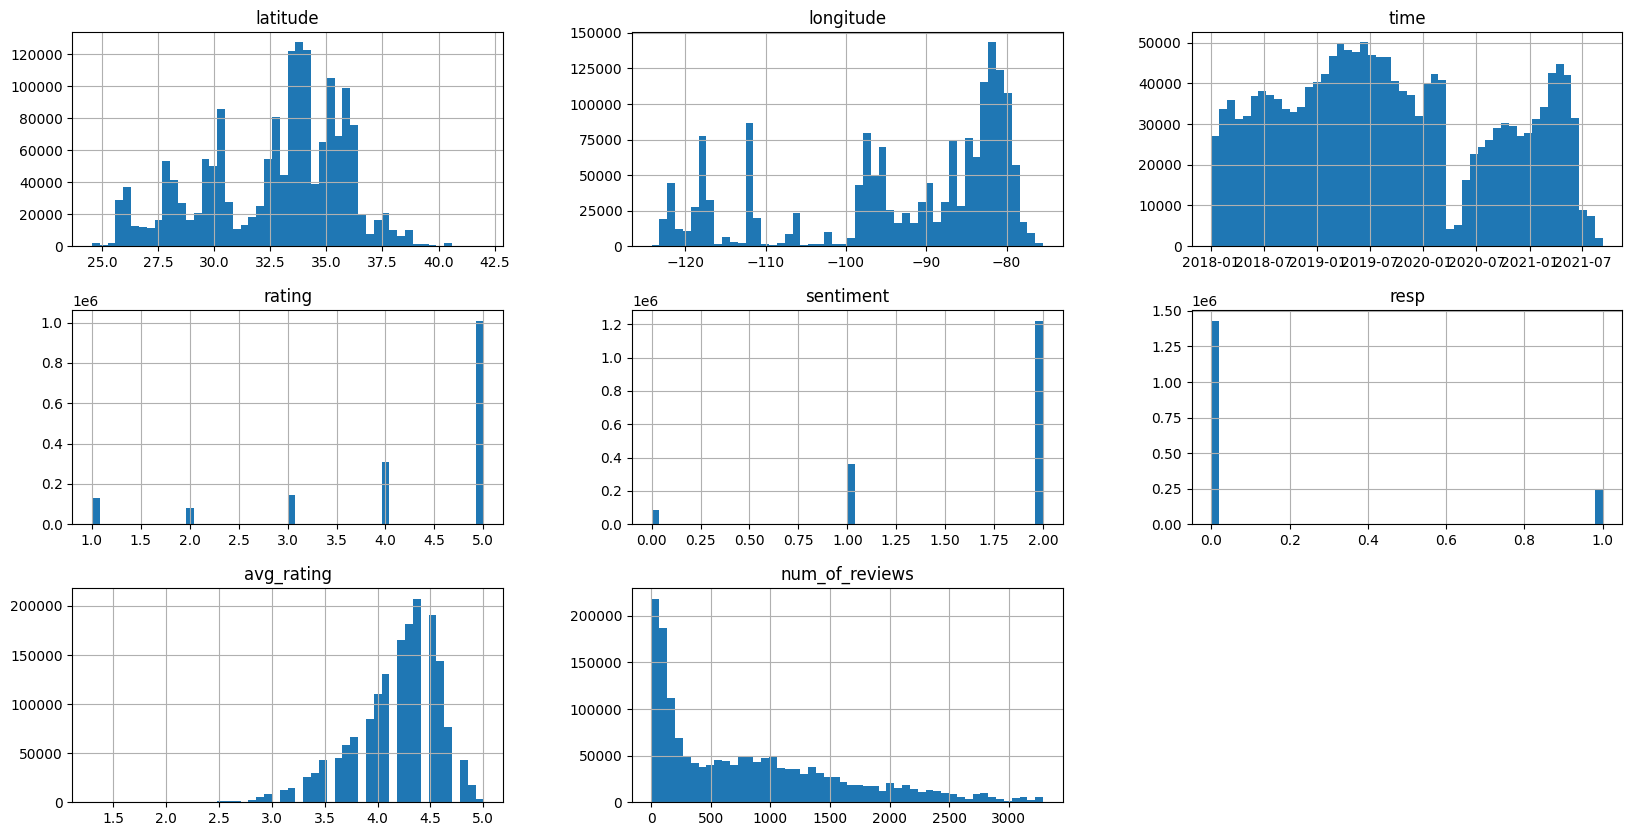

In [ ]:
maestro_ml.hist(bins=50, figsize=(20,10))
plt.show()

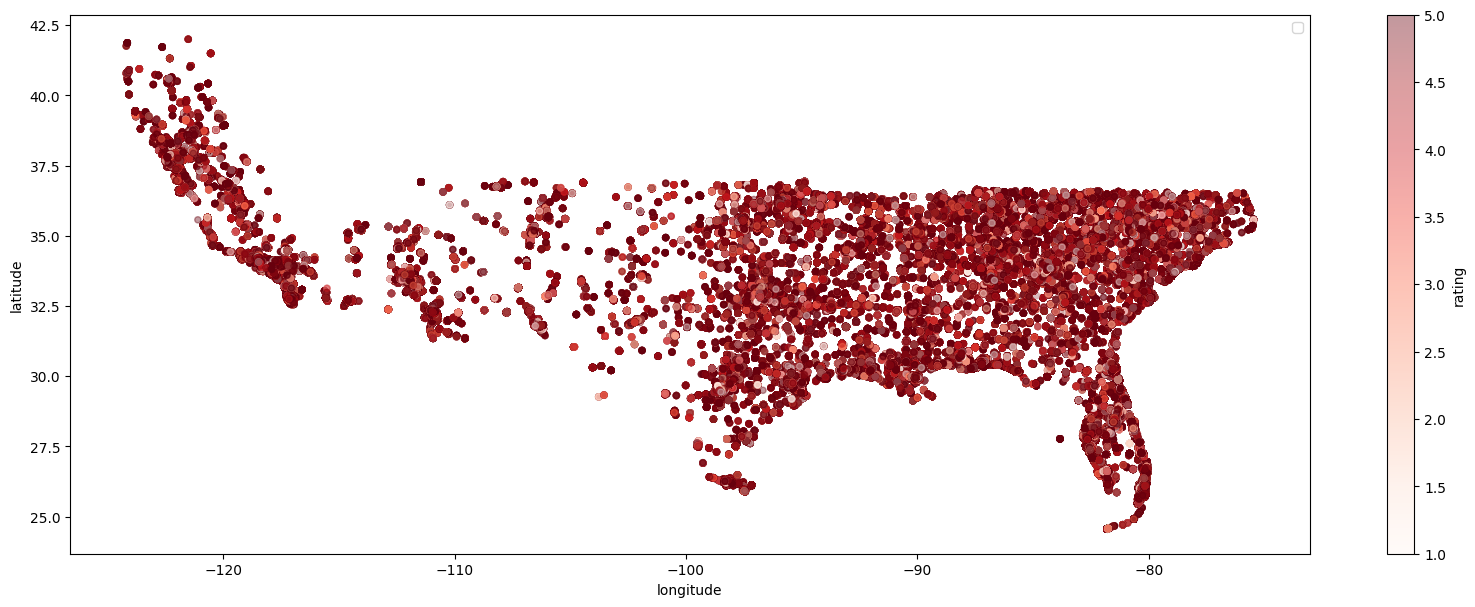

In [ ]:
maestro_ml.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(20,7),
                c="rating", cmap=plt.get_cmap("Reds"), colorbar=True,sharex=False)
plt.legend()
plt.show()

# EDA. Relación de variables

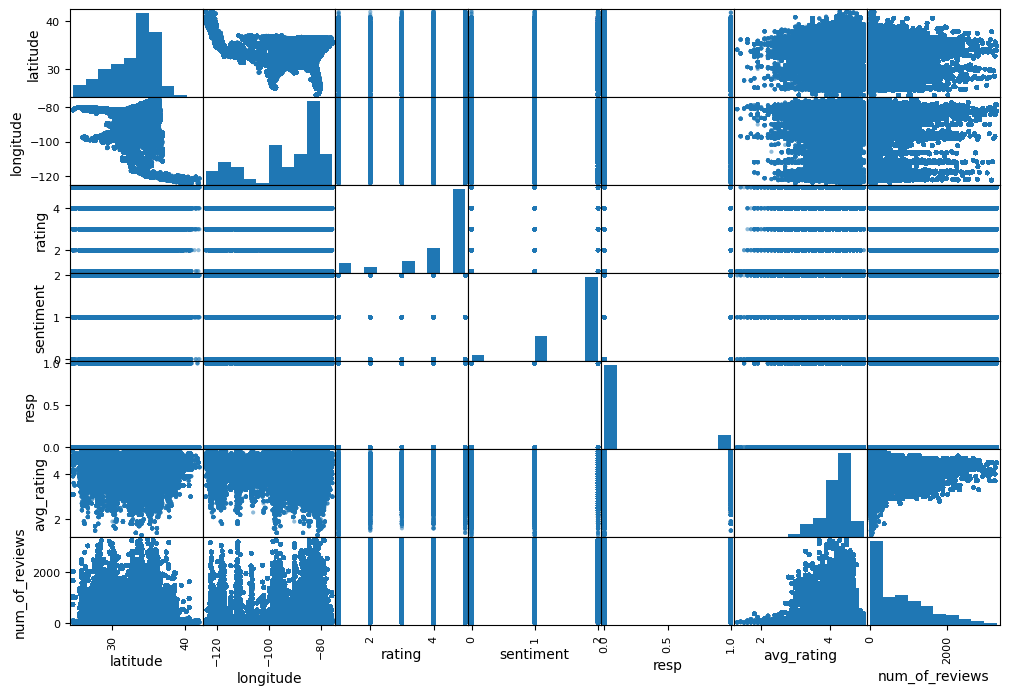

In [ ]:
# attributes = ['Banda ancha fija','Dial up','Mbps (Media de bajada)','ADSL','Cablemodem','Fibra óptica','Wireless','Total','Accesos por cada 100 hogares']
scatter_matrix(maestro_ml, figsize=(12, 8))
plt.show()

<ipython-input-18-02eb58571681>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(maestro_ml.corr(), annot=True, cmap="YlGnBu", annot_kws={"size": 15}, cbar=True, square=True, fmt='.2f')


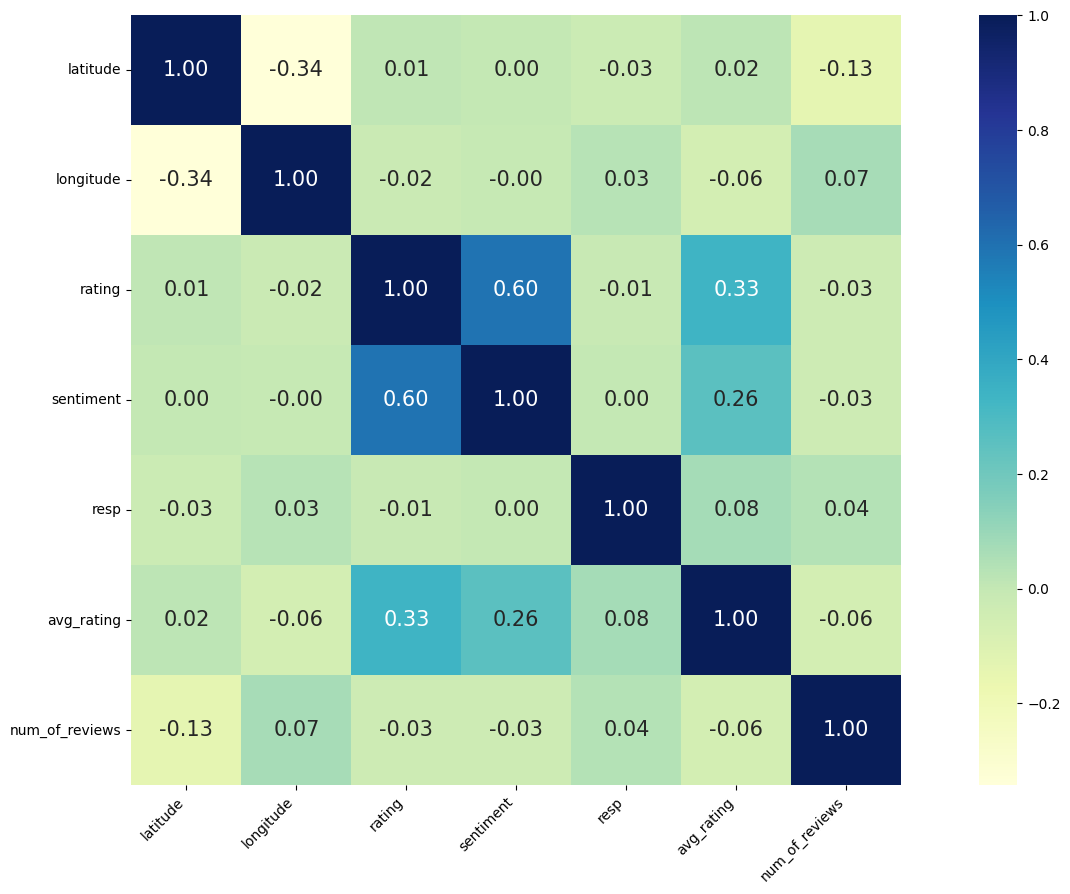

In [ ]:
# Hacemos un mapa de calor para ver la relación entre las variables de una manera más amena

plt.figure(figsize=(20, 10))

sns.heatmap(maestro_ml.corr(), annot=True, cmap="YlGnBu", annot_kws={"size": 15}, cbar=True, square=True, fmt='.2f')
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)
plt.show()

# Preparacion de datos

In [ ]:
maestro_copy = maestro_ml.copy()

rate = rating + sentiment + resp + Service0	+ Service1 +	Service2 +	Accessibility0 +	Offerings0 +	Offerings1 +	Offerings2 +	Amenities0 +	Atmosphere0 +	Crowd0

In [ ]:
maestro_copy.columns

Index(['state', 'name_y', 'category', 'gmap_id', 'latitude', 'longitude',
       'time', 'rating', 'sentiment', 'resp', 'avg_rating', 'num_of_reviews',
       'Service0', 'Service1', 'Service2', 'Accessibility0', 'Offerings0',
       'Offerings1', 'Offerings2', 'Amenities0', 'Atmosphere0', 'Crowd0'],
      dtype='object')

codificacion de enteros

In [ ]:
# Aplicar la codificación de enteros
maestro_copy['category_int'] = maestro_copy['category'].astype('category').cat.codes

In [ ]:
# Aplicar la codificación de enteros
maestro_copy['state_int'] = maestro_copy['state'].astype('category').cat.codes

codificacion de frecuencia

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Service0'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Service0_int'] = maestro_copy['Service0'].map(mapeo)


In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Service1'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Service1_int'] = maestro_copy['Service1'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Service2'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Service2_int'] = maestro_copy['Service2'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Accessibility0'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Accessibility0_int'] = maestro_copy['Accessibility0'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Offerings0'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Offerings0_int'] = maestro_copy['Offerings0'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Offerings1'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Offerings1_int'] = maestro_copy['Offerings1'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Offerings2'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Offerings2_int'] = maestro_copy['Offerings2'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Amenities0'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Amenities0_int'] = maestro_copy['Amenities0'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Atmosphere0'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Atmosphere0_int'] = maestro_copy['Atmosphere0'].map(mapeo)

In [ ]:
# Calcular la frecuencia de cada categoría
frecuencia = maestro_copy['Crowd0'].value_counts()

# Ordenar la serie de frecuencias de menor a mayor
frecuencia = frecuencia.sort_values(ascending=True)

# Crear un diccionario que mapea cada categoría con un número
mapeo = {categoria: indice+1 for indice, categoria in enumerate(frecuencia.index)}

# Asignar el valor 0 a la categoría 'No'
mapeo['No'] = 0

# Aplicar la codificación de frecuencia
maestro_copy['Crowd0_int'] = maestro_copy['Crowd0'].map(mapeo)

In [ ]:
# Sumar los valores de las columnas y crear una nueva columna 'rate'
maestro_copy['top'] = maestro_copy['rating'] + maestro_copy['sentiment'] + maestro_copy['resp']
maestro_copy['services'] = (maestro_copy['Service0_int'] + maestro_copy['Service1_int'] + maestro_copy['Service2_int']  + maestro_copy['Accessibility0_int'] + maestro_copy['Offerings0_int'] + maestro_copy['Offerings1_int'] + maestro_copy['Offerings2_int'] + maestro_copy['Amenities0_int'] + maestro_copy['Atmosphere0_int'] + maestro_copy['Crowd0_int'])/10
maestro_copy['rate'] = (maestro_copy['top'] + maestro_copy['services'])/2
maestro_copy['class'] = (maestro_copy['top'] == 8) & (maestro_copy['rate'] > 9)
maestro_copy['class'] = maestro_copy['class'].astype(int)

In [ ]:
maestro_copy[maestro_copy['class'] == 0].iloc[:, 22:]

,category_int,state_int,Service0_int,Service1_int,Service2_int,Accessibility0_int,Offerings0_int,Offerings1_int,Offerings2_int,Amenities0_int,Atmosphere0_int,Crowd0_int,top,services,rate,class
0,190,10,15,3,4,11,0,0,0,0,0,0,7,3.3,5.15,0
1,55,13,15,5,8,9,25,0,0,0,9,0,4,7.1,5.55,0
2,9,13,15,4,8,10,0,0,0,0,0,0,7,3.7,5.35,0
3,190,4,5,5,0,11,0,0,0,0,0,0,7,2.1,4.55,0
4,9,13,15,4,8,10,0,0,0,0,0,0,7,3.7,5.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753164,217,6,15,11,11,9,24,22,21,10,9,7,5,13.9,9.45,0
1753165,217,6,15,11,11,9,24,22,21,10,9,7,7,13.9,10.45,0
1753166,217,6,15,11,11,9,24,22,21,10,9,7,7,13.9,10.45,0
1753167,217,6,15,11,11,9,24,22,21,10,9,7,7,13.9,10.45,0


In [ ]:
maestro_copy['class'].value_counts()

0    1554270
1     116589
Name: class, dtype: int64

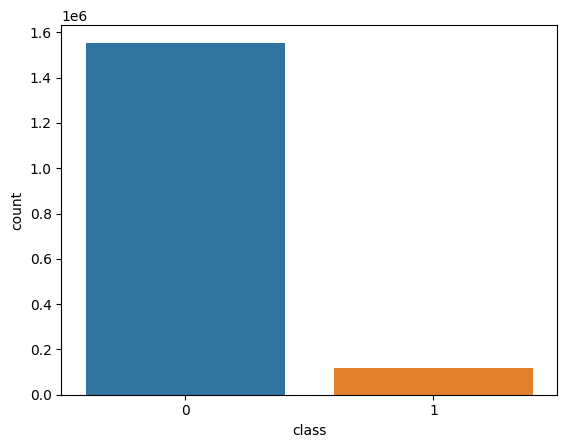

In [ ]:
sns.countplot(x='class', data=maestro_copy)
plt.show()

In [ ]:
corr_matrix = maestro_copy.corr()
corr_matrix['class'].sort_values(ascending=False)

<ipython-input-100-bb1815d8bca8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = maestro_copy.corr()


class                 1.000000
resp                  0.709725
top                   0.343491
rate                  0.195363
rating                0.189087
sentiment             0.163861
avg_rating            0.113154
Service1_int          0.061506
Service0_int          0.052076
Service2_int          0.035309
services              0.031852
Accessibility0_int    0.031424
category_int          0.031215
longitude             0.027137
Offerings1_int        0.022205
Offerings2_int        0.022111
Offerings0_int        0.018322
state_int             0.013932
Atmosphere0_int       0.012534
Amenities0_int        0.003551
num_of_reviews        0.001109
Crowd0_int           -0.012515
latitude             -0.020784
Name: class, dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree

from collections import Counter

In [ ]:
maestro_modelo = maestro_copy[['category_int', 'state_int', 'Service0_int', 'Service1_int', 'Service2_int', 'Accessibility0_int', 'Offerings0_int',
                                'Offerings1_int', 'Offerings2_int', 'Amenities0_int', 'Atmosphere0_int', 'Crowd0_int', 'class']]

In [ ]:
X = maestro_modelo.iloc[:, :-1].values # Variables independientes
y = maestro_modelo.iloc[:, -1].values # Variable dependiente (la que queremos predecir)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [ ]:
# opción de escalar los datos, es indiferente en este caso en particular que se obtienen los mismos resultados

sc = StandardScaler() # Creamos el objeto para escalar las variables

X_train = sc.fit_transform(X_train) # Escalamos las variables de entrenamiento
X_test = sc.transform(X_test) # Escalamos las variables de test

In [ ]:
# la variable objetivo esta desbalanceada, por lo tanto se hace la medida oversampling para entrenar la data usando SMOTE

counter = Counter(y_train)
print('Antes',counter)

smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('Despues',counter)

Antes Counter({0: 1088067, 1: 81534})
Despues Counter({0: 1088067, 1: 1088067})


# Arbol de decision

In [ ]:
# se entrena un modelo de Arbol de Decisión

kf = KFold(n_splits=5) # 5 folds

classifier = DecisionTreeClassifier(max_depth = 30, criterion='entropy')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30)

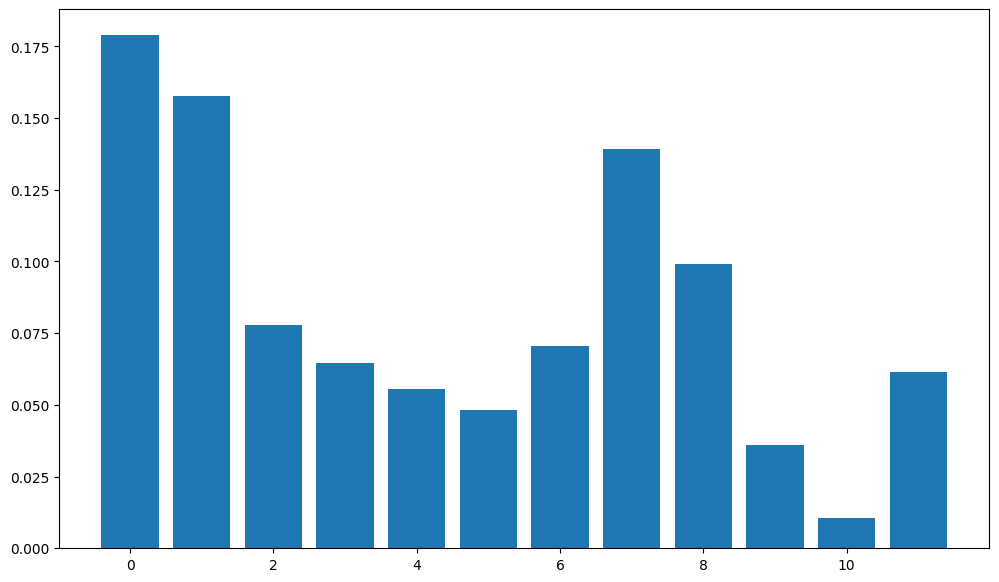

In [ ]:
# Obtiene la importancia de cada variable
importances = classifier.feature_importances_

# Grafica la importancia de cada variable
plt.figure(figsize=(12,7))
plt.bar(range(len(importances)), importances)
plt.show()

In [ ]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [ ]:
# matriz de confusion

cm = confusion_matrix(y_test, y_pred)
print(cm)
round(accuracy_score(y_test, y_pred),2)

[[386973  79230]
 [  3370  31685]]


0.84

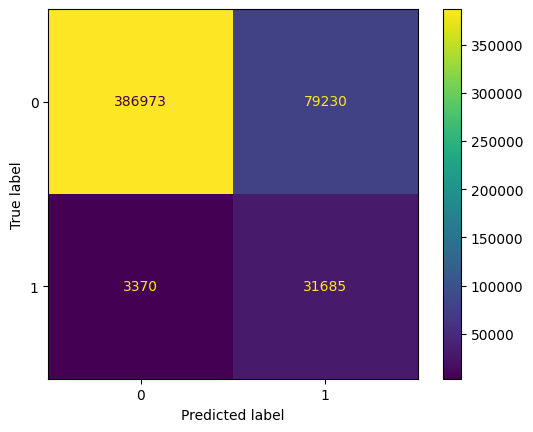

In [ ]:
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    466203
           1       0.29      0.90      0.43     35055

    accuracy                           0.84    501258
   macro avg       0.64      0.87      0.67    501258
weighted avg       0.94      0.84      0.87    501258



In [ ]:
score = classifier.score(X_train,y_train)

print("Metrica del modelo", score)

scores = cross_val_score(classifier, X_train, y_train, cv=kf, scoring="accuracy") #cv 5 folds, el scoring por defecto es el accuracy pero se puede cambiar por f1, recall, precision, etc.

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

preds = classifier.predict(X_test)

score_pred = metrics.accuracy_score(y_test, preds)

print("Metrica en Test", score_pred)

Metrica del modelo 0.8911151611068069
Metricas cross_validation [0.81502756 0.81369262 0.87119595 0.90247158 0.90348003]
Media de cross_validation 0.8611735501152415
Metrica en Test 0.8352146000662334


In [ ]:
print('Exactitud en el set de entrenamiento: {0: .2f}'.format(classifier.score(X_train, y_train)))
print('Exactitud en el set de testeo: {0: .2f}'.format(classifier.score(X_test, y_test)))

Exactitud en el set de entrenamiento:  0.89
Exactitud en el set de testeo:  0.84


In [ ]:
print('La cantidad de nodos del modelo clasificador es:', classifier.tree_.max_depth)

La cantidad de nodos del modelo clasificador es: 30


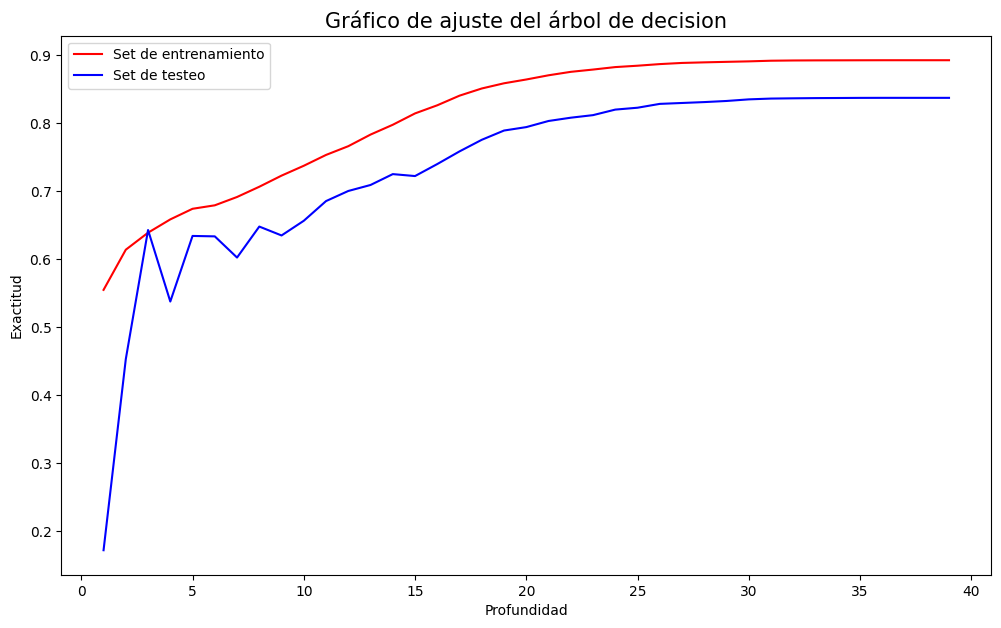

In [ ]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(1, 40))

for deep in max_deep_list:
    clf = DecisionTreeClassifier(max_depth=deep, criterion='entropy')
    clf.fit(X_train, y_train)
    train_prec.append(clf.score(X_train, y_train))
    eval_prec.append(clf.score(X_test, y_test))

plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.ylabel('Exactitud')
plt.xlabel('Profundidad')
plt.show()

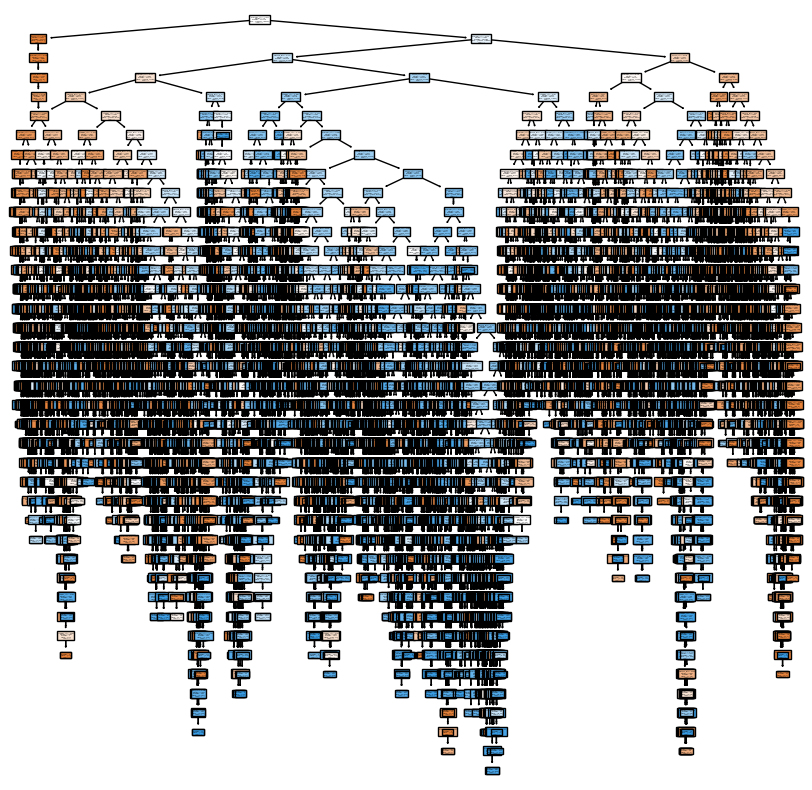

In [ ]:
plt.figure(figsize = (10,10))
tree.plot_tree(classifier, feature_names = list(maestro_modelo.drop(['class'], axis=1)), class_names= ['0', '1'], filled=True)
plt.show()

In [ ]:
acc_decision_tree = round(classifier.score(X_train, y_train) * 100, 2)
print(acc_decision_tree,'%')

89.11 %


In [ ]:
# probabilidad de exito con las caracteristicas escogidas (para 1 - premium)

x_prueba = pd.DataFrame(columns=( 'category_int', 'state_int', 'Service0_int', 'Service1_int', 'Service2_int', 'Accessibility0_int', 'Offerings0_int',
                                  'Offerings1_int', 'Offerings2_int', 'Amenities0_int', 'Atmosphere0_int', 'Crowd0_int','class'))
x_prueba.loc[0] = (134,4,11,0,0,9,23,18,18,11,9,8,1)
y_pred = classifier.predict(x_prueba.drop(['class'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = classifier.predict_proba(x_prueba.drop(['class'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: 97.55%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# probabilidad de exito con las caracteristicas escogidas (para 0 - regular)

x_prueba = pd.DataFrame(columns=( 'category_int', 'state_int', 'Service0_int', 'Service1_int', 'Service2_int', 'Accessibility0_int', 'Offerings0_int',
                                  'Offerings1_int', 'Offerings2_int', 'Amenities0_int', 'Atmosphere0_int', 'Crowd0_int','class'))
x_prueba.loc[0] = (190,10,15,3,4,11,0,0,0,0,0,0,0)
y_pred = classifier.predict(x_prueba.drop(['class'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = classifier.predict_proba(x_prueba.drop(['class'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 100.0%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# probabilidad de exito con las caracteristicas escogidas (para 0 - regular)

x_prueba = pd.DataFrame(columns=( 'category_int', 'state_int', 'Service0_int', 'Service1_int', 'Service2_int', 'Accessibility0_int', 'Offerings0_int',
                                  'Offerings1_int', 'Offerings2_int', 'Amenities0_int', 'Atmosphere0_int', 'Crowd0_int','class'))
x_prueba.loc[0] = (217,6,15,11,11,9,24,22,21,10,9,7,0)
y_pred = classifier.predict(x_prueba.drop(['class'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = classifier.predict_proba(x_prueba.drop(['class'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: 97.51%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


# Random Forest

In [ ]:
# importancia de las variables

# Entrena tu modelo
model = RandomForestClassifier(max_depth = None, criterion='entropy')
model.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy')

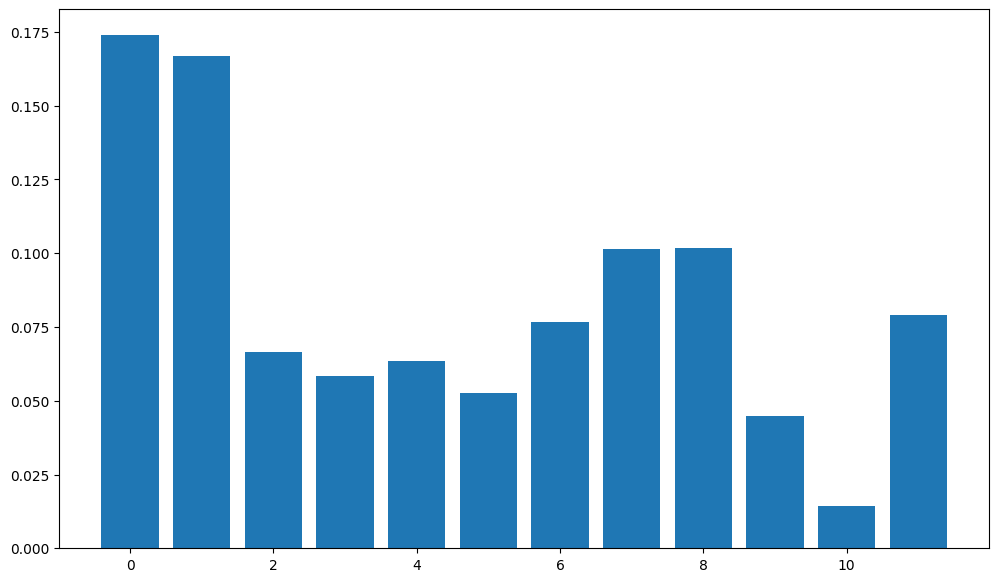

In [ ]:
# Obtiene la importancia de cada variable
importances = model.feature_importances_

# Grafica la importancia de cada variable
plt.figure(figsize=(12,7))
plt.bar(range(len(importances)), importances)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [ ]:
# matriz de confusion

cm1 = confusion_matrix(y_test, y_pred)
print(cm1)
round(accuracy_score(y_test, y_pred),2)

[[388055  78148]
 [  3366  31689]]


0.84

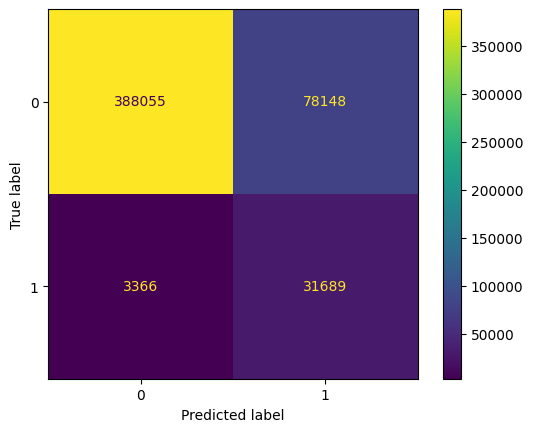

In [ ]:
cm_display = ConfusionMatrixDisplay(cm1)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    466203
           1       0.29      0.90      0.44     35055

    accuracy                           0.84    501258
   macro avg       0.64      0.87      0.67    501258
weighted avg       0.94      0.84      0.87    501258



In [ ]:
print('Exactitud en el set de entrenamiento: {0: .2f}'.format(model.score(X_train, y_train)))
print('Exactitud en el set de testeo: {0: .2f}'.format(model.score(X_test, y_test)))

Exactitud en el set de entrenamiento:  0.89
Exactitud en el set de testeo:  0.84


In [ ]:
max_depth = 0
for tree in model.estimators_:
    if tree.tree_.max_depth > max_depth:
        max_depth = tree.tree_.max_depth
print('La cantidad de nodos del modelo clasificador es:', max_depth)


La cantidad de nodos del modelo clasificador es: 47


In [ ]:
# probabilidad de exito con las caracteristicas escogidas (para 1 - premium)

x_prueba = pd.DataFrame(columns=( 'category_int', 'state_int', 'Service0_int', 'Service1_int', 'Service2_int', 'Accessibility0_int', 'Offerings0_int',
                                  'Offerings1_int', 'Offerings2_int', 'Amenities0_int', 'Atmosphere0_int', 'Crowd0_int','class'))
x_prueba.loc[0] = (134,4,11,0,0,9,23,18,18,11,9,8,1)
y_pred = model.predict(x_prueba.drop(['class'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = classifier.predict_proba(x_prueba.drop(['class'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: 97.55%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# probabilidad de exito con las caracteristicas escogidas (para 0 - regular)

x_prueba = pd.DataFrame(columns=( 'category_int', 'state_int', 'Service0_int', 'Service1_int', 'Service2_int', 'Accessibility0_int', 'Offerings0_int',
                                  'Offerings1_int', 'Offerings2_int', 'Amenities0_int', 'Atmosphere0_int', 'Crowd0_int','class'))
x_prueba.loc[0] = (217,6,15,11,11,9,24,22,21,10,9,7,0)
y_pred = model.predict(x_prueba.drop(['class'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = classifier.predict_proba(x_prueba.drop(['class'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 2.49%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
